**Run the following two cells before you begin.**

In [43]:
%autosave 10

Autosaving every 10 seconds


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [45]:
# Import data set
df = pd.read_csv('cleaned_data.csv')

In [46]:
# Create features list
features_response = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 
                     'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                     'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                     'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    df[features_response].values,
    df['default payment next month'].values,
    test_size=0.2, random_state=24)

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [48]:
min_max_sc = MinMaxScaler()

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [49]:
new_lr = LogisticRegression(solver='saga', penalty='l1', max_iter = 1000, random_state=1)

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [50]:
from sklearn.pipeline import Pipeline
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', new_lr)])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [51]:
# Use `get_params`
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('model',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=1000,
                      multi_class='warn', n_jobs=None, penalty='l1',
                      random_state=1, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=1, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_inte

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [52]:
# View what `model__C` is set to currently
scale_lr_pipeline.get_params()['model__C']

1.0

In [53]:
# Change `model__C` to 2
scale_lr_pipeline.set_params(model__C = 2)

scale_lr_pipeline.get_params()['model__C']

2

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [54]:
C_vals = np.float(10)**np.array([2,1,0,-1,-2,-3])
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [55]:
n_folds = 4
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=1)

_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [56]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        scale_lr_pipeline.set_params(model__C = C_vals[c_val_counter])
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [57]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

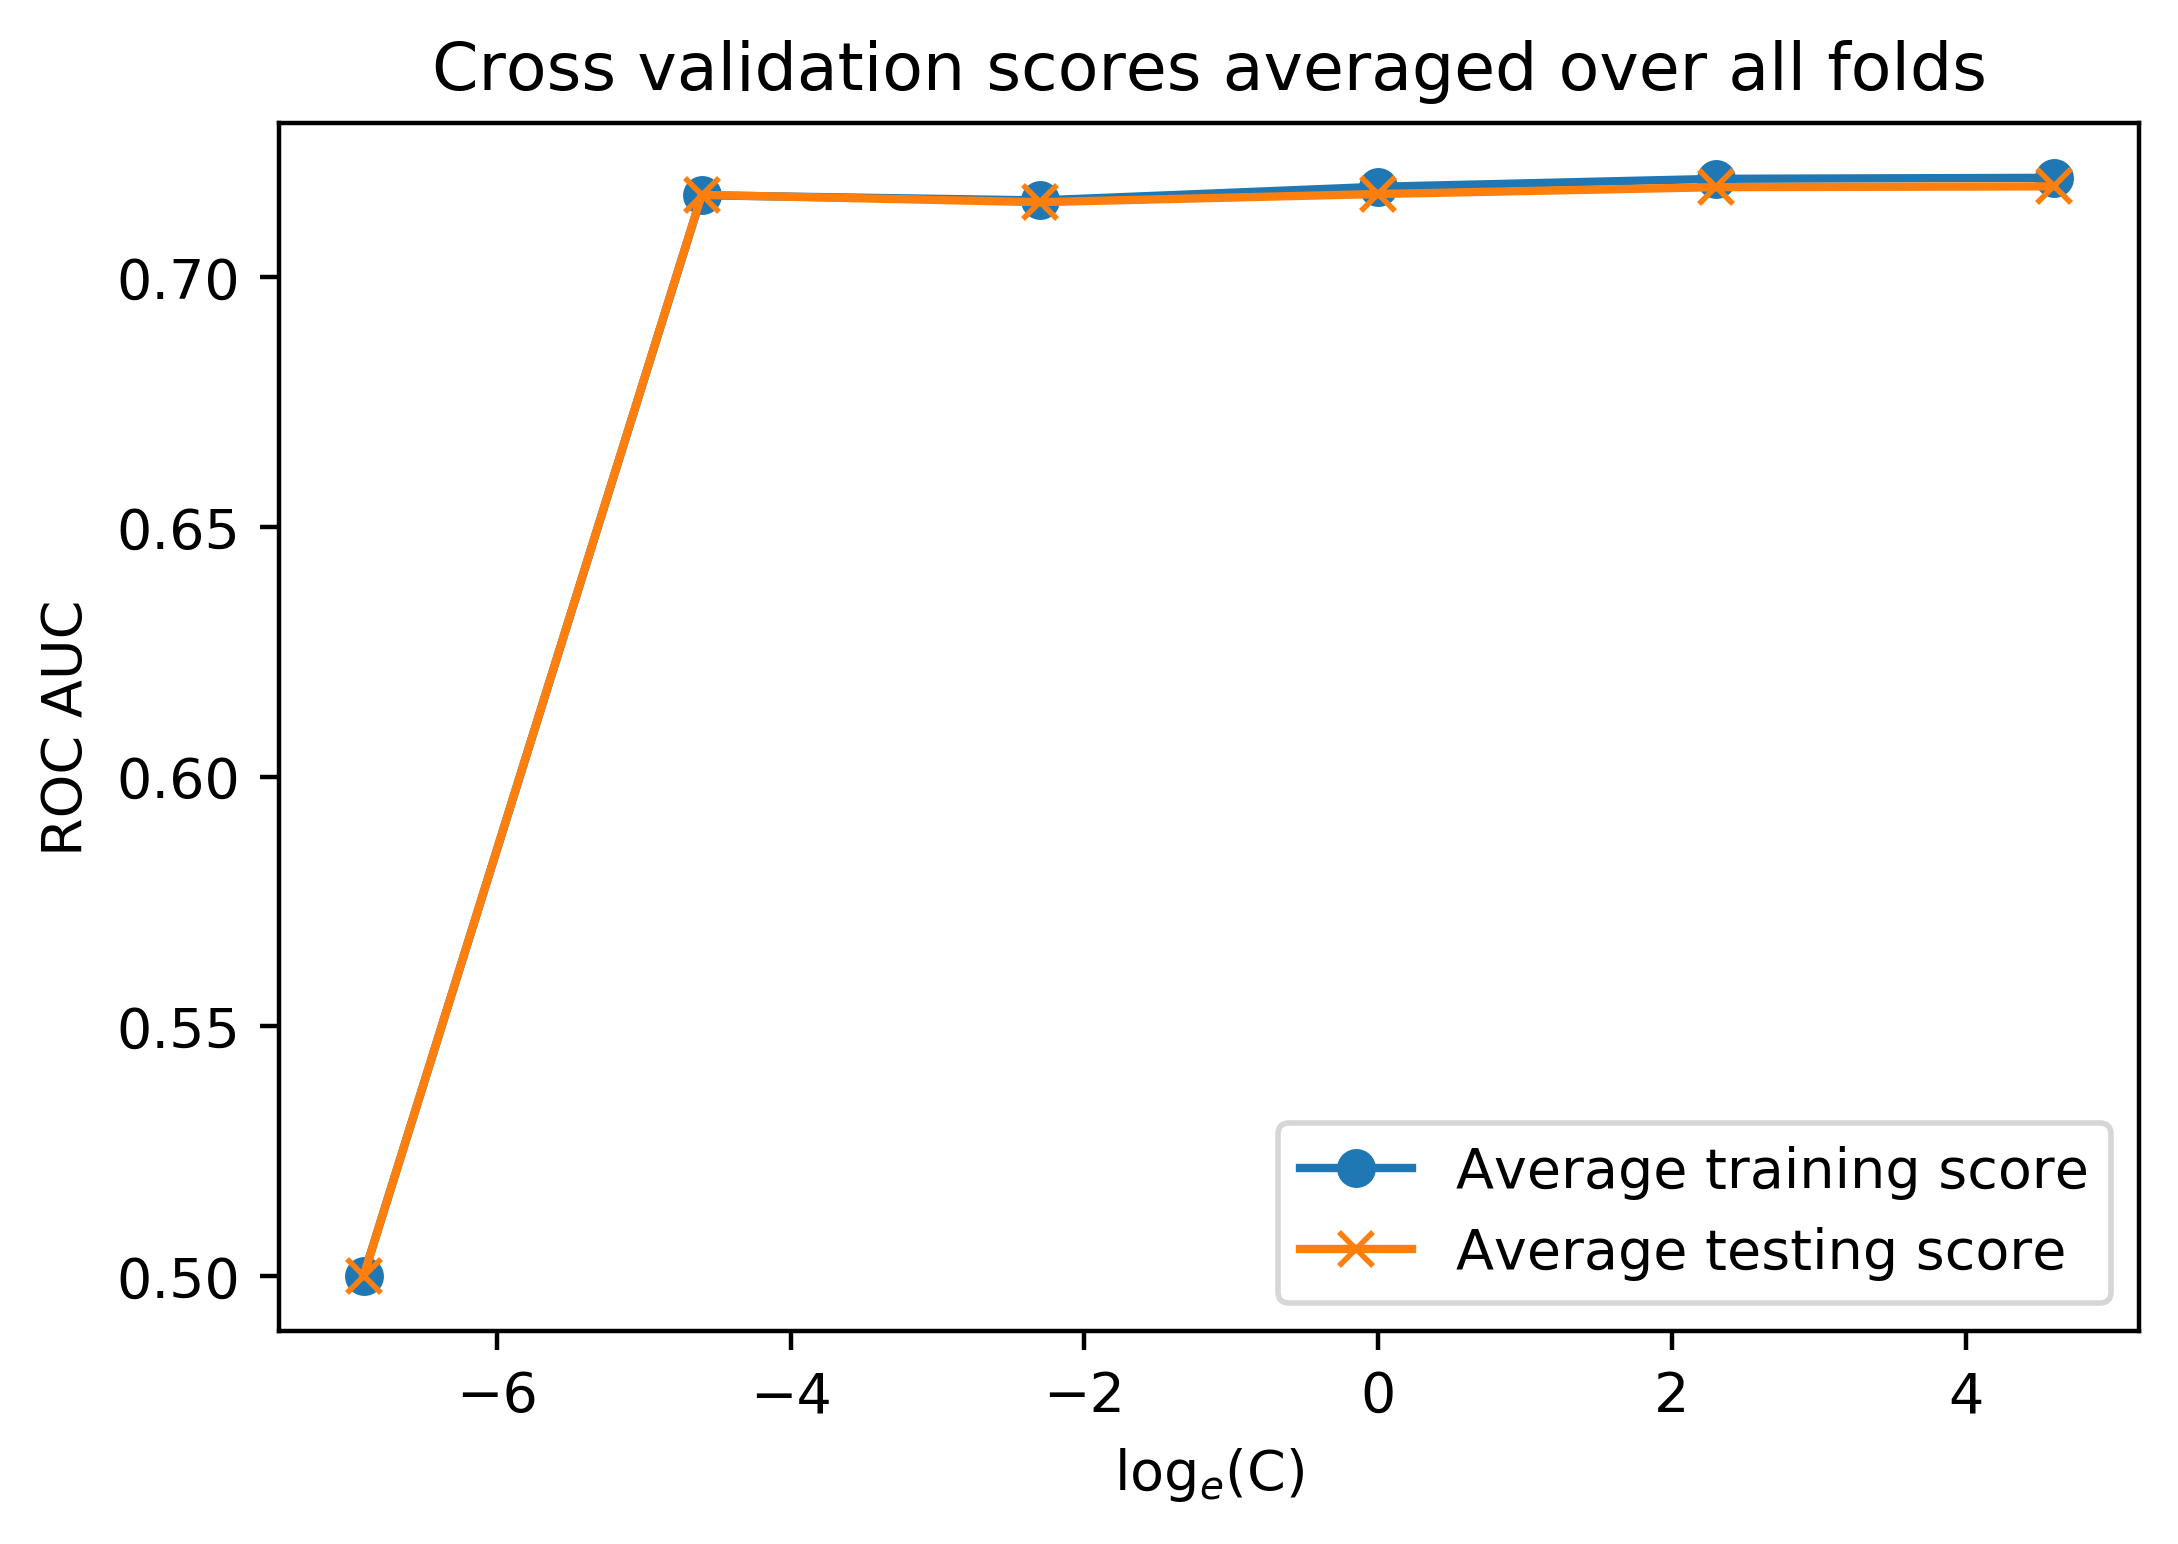

In [58]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

plt.plot(np.log(C_vals), np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(np.log(C_vals), np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{e}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [59]:
from sklearn.preprocessing import PolynomialFeatures
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

new_features = make_interactions.fit_transform( df[features_response].values)
new_features.shape

(26664, 153)

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [60]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    new_features,
    df['default payment next month'].values,
    test_size=0.2, random_state=24)

In [61]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.

cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_new_train, y_new_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

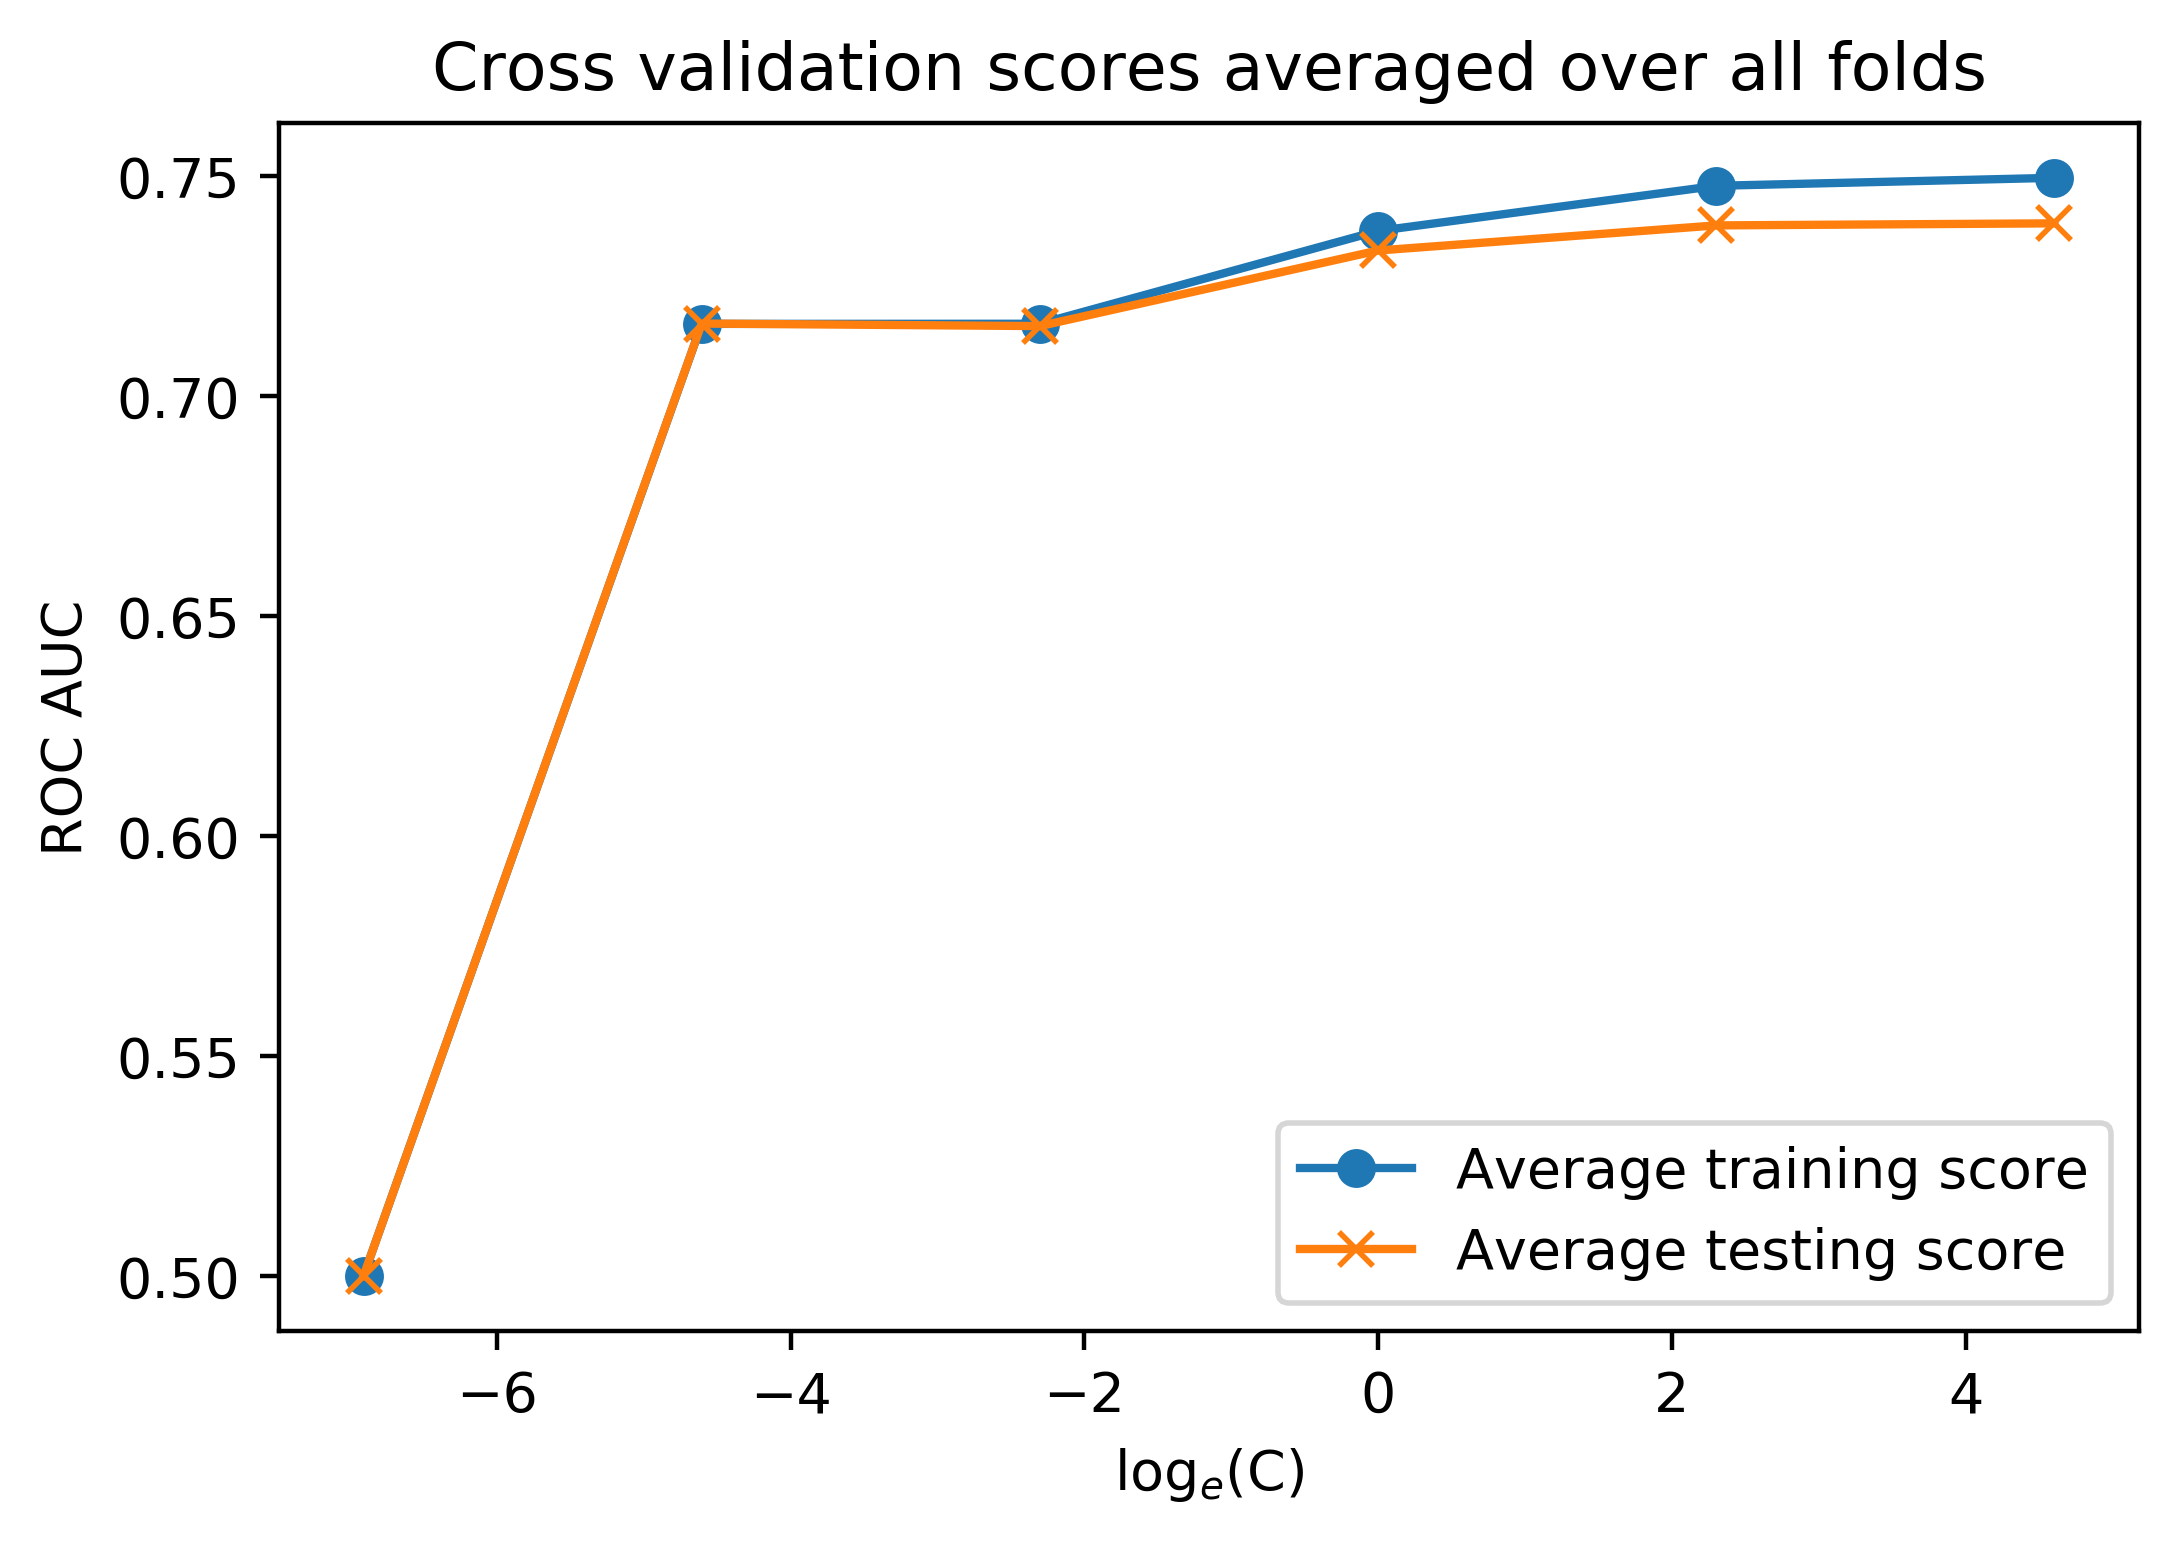

In [62]:
# Plot the average training and testing ROC AUC across folds, for each C value.
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

plt.plot(np.log(C_vals), np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(np.log(C_vals), np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{e}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**

In [64]:
interpretation = '''The average cross-validation testing performance improves 
    with the interaction features but only by a small value 
    for c >= -2  and almost no change for c < -2.
So, the regularization is useful to some extent for c >= -2.'''

print(interpretation)

The average cross-validation testing performance improves 
    with the interaction features but only by a small value 
    for c >= -2  and almost no change for c < -2.
So, the regularization is useful to some extent for c >= -2.
